### Introduction

### Training Process

#### Step 1: Look for faces from video frames

#### Step 2: Calculate the embedding vector for every face

    A face embedding is a vector that represents the features extracted from the face.
    For example, another vector that is close (by some measure) may be the same person,
    whereas another vector that is far (by some measure) may be a different person.

#### Step 3: Perform the clustering of the embedding vectors
     
    The goal of the clustering is to figure out which set of the embedding corresponds to the user.
    We use DBScan for clustering.

    We do not know how many people will appear on the images.
    As a result, we should not use “number_of_clusters” as an input to our clustering algorithm.
    
    For this reason, we used DBScan. Major challenge of using DBSCAN algorithm is to find right
    set hyper parameters(eps and min_samples values) to fit in to the algorithm for getting accurate result.    

### Importing the Libraries

In [1]:
from numpy import unique
from numpy import where
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from itertools import product 
from plot_utils import plot_clusters, plot_pca_variance
import time
from face_detection import FaceDetection
from action_recognition import ActionRecognition
import cv2
import seaborn as sns
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Haliva\anaconda3\envs\myenv\lib\site-packages\tensorflow\pyth

### Collect Faces from video frames

In [2]:
action_recognition = ActionRecognition()
faceDetection = FaceDetection()
vs = cv2.VideoCapture("video.mp4")
faces = []


# Loop Video Stream
while True:

    (grabbed, frame) = vs.read()
    
    if frame is None:
        break
        
    # Step 2: Calculate the embedding vector for every face
    temp = faceDetection.detect_faces(frame, "video.mp4", 0.95)
    faces.extend(temp)
    
    frame = cv2.resize(frame, (300, 300))
    cv2.imshow('camera2',frame) 
    
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break
    
cv2.destroyAllWindows()

[2021-03-09 01:30:37,374] [TfPoseEstimator] [INFO] loading graph from C:\Users\Haliva\Data Science\Data Science Course - Final Project\libs\action_recognition\models\graph/mobilenet_thin/graph_opt.pb(default size=656x368)


mobilenet_thin
656x368
models/trained_classifier.pickle
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Feature Reduction - PCA - Principal Components Analysis

In [3]:
 def get_best_pca_dimensions(data, threshold_variance = 90):

    print("\n-------------------- get_best_pca_dimensions --------------------\n")

    n_components =  min(len(data), len(data[0]))
    sns.set_theme()

    pca = PCA(n_components=n_components)
    pca.fit(data)
    variance = pca.explained_variance_ratio_ 
    var=np.cumsum(np.round(variance, 3)*100)

    plot_pca_variance(var)

    best_pca_dimensions =  next(item[0] for item in enumerate(var) if item[1] > threshold_variance)
    print("best_pca_dimensions for", threshold_variance ,"% Variance is: ", best_pca_dimensions, "Features\n")
    return best_pca_dimensions

In [4]:
def create_pca(faces, face_encodings, n_components = 20):

    pca = PCA(n_components=n_components)
    pca.fit(face_encodings)

    pca_scale = pca.transform(face_encodings)
    pca_df = pd.DataFrame(pca_scale)

    pca_df_all_data = pd.DataFrame()
    pca_df_all_data['face_location'] = faces.face_location
    pca_df_all_data['image_path'] = faces.image_path
    # pca_df_all_data['face_encodings'] = pd.Series(pca_scale.tolist())
    pca_df_all_data['face_encodings'] = face_encodings

    return pca_df_all_data, pca_df


-------------------- get_best_pca_dimensions --------------------



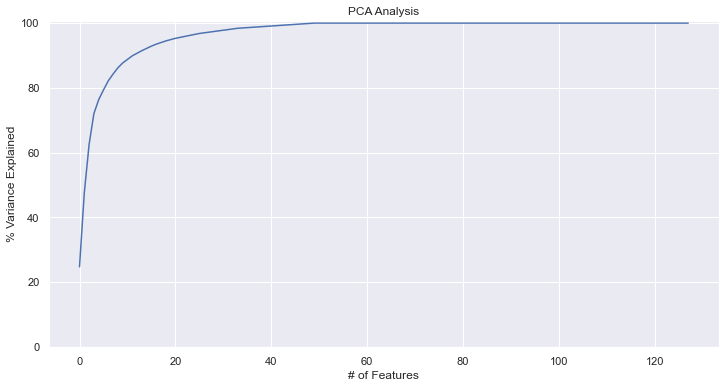

best_pca_dimensions for 90 % Variance is:  12 Features



In [5]:
clustring_algorithms_results = []
faces = pd.DataFrame(faces)
face_encodings = faces['face_encoding'].tolist()
best_pca_dimensions = get_best_pca_dimensions(face_encodings)
pca_df_all_data, pca_df = create_pca(faces, face_encodings, best_pca_dimensions)

In [6]:
faces

,face_encoding,face_location,image_path
0,"[-1.1912599, -0.8228302, -0.40031707, -1.63635...","[1222, 50, 1525, 432]",video.mp4
1,"[-1.2779435, -0.87038517, -0.37021828, -1.7669...","[1249, 52, 1546, 434]",video.mp4
2,"[-1.0201672, -0.60240805, -0.6928619, -1.40743...","[1250, 22, 1562, 430]",video.mp4
3,"[-1.1640614, -0.59016705, -0.5768476, -1.29468...","[1299, 11, 1629, 441]",video.mp4
4,"[-0.95789826, -0.18442962, -0.9021818, -1.3385...","[1324, 19, 1654, 440]",video.mp4
...,...,...,...
295,"[-1.4184235, -0.6505166, -0.9390658, -0.624670...","[1533, 452, 1830, 870]",video.mp4
296,"[-1.1496332, -0.26877365, -0.20659196, -0.3247...","[737, 590, 985, 918]",video.mp4
297,"[-1.4349687, -0.41537136, -1.2884346, -0.72868...","[1537, 469, 1833, 889]",video.mp4
298,"[-1.1718473, -0.62041783, -0.26983872, -0.1617...","[779, 621, 1003, 923]",video.mp4


In [7]:
pca_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,6.632051,5.462099,-5.114827,-0.721870,-0.420408,-0.581613,-1.126621,-0.311334,-1.596250,-1.181629,1.237681,-2.154640
1,7.063499,5.764046,-4.736115,-0.788277,0.005537,-0.777543,-1.780529,-0.315537,-1.299415,-1.275315,1.460270,-2.071229
2,7.209326,6.061231,-4.227365,-0.543843,-0.343146,-0.501081,-1.911965,-0.314760,-0.921060,-1.292680,1.264362,-1.965599
3,7.631540,5.803324,-4.597648,-0.728529,-0.956847,0.268161,-1.769117,-0.682694,-0.840343,-1.317338,1.162375,-1.268344
4,7.703223,5.364998,-4.360388,-1.022363,-0.997751,0.583872,-1.171742,-0.946971,-1.261848,-1.638705,0.530497,-1.634429
5,7.628506,4.863581,-3.849565,-1.537682,-0.855728,0.148452,-1.025853,-0.004170,-1.264347,-1.966710,0.326345,-1.691318
6,6.933752,5.416652,-4.739520,-0.321093,-0.706659,-0.550434,-1.240540,-0.712841,-0.991507,-2.131953,1.166796,-0.688864
7,3.956941,-3.253599,3.965481,1.705531,-1.897862,9.600417,1.613751,0.244367,1.317958,-0.053662,1.574837,-0.986045
8,3.534425,-3.273304,3.703535,1.947101,-1.347885,9.847428,1.660205,0.533434,0.843553,0.145402,1.386519,-1.017408
9,3.180732,-1.827404,2.871335,2.154563,-1.573911,10.384267,1.257343,0.042798,1.825613,0.592592,2.141253,-0.442133


In [8]:
pca_df_all_data.head(10)

,face_location,image_path,face_encodings
0,"[1222, 50, 1525, 432]",video.mp4,"[-1.1912599, -0.8228302, -0.40031707, -1.63635..."
1,"[1249, 52, 1546, 434]",video.mp4,"[-1.2779435, -0.87038517, -0.37021828, -1.7669..."
2,"[1250, 22, 1562, 430]",video.mp4,"[-1.0201672, -0.60240805, -0.6928619, -1.40743..."
3,"[1299, 11, 1629, 441]",video.mp4,"[-1.1640614, -0.59016705, -0.5768476, -1.29468..."
4,"[1324, 19, 1654, 440]",video.mp4,"[-0.95789826, -0.18442962, -0.9021818, -1.3385..."
5,"[1367, 30, 1675, 423]",video.mp4,"[-1.3983204, -0.581247, -0.74171174, -1.205270..."
6,"[1418, 32, 1747, 431]",video.mp4,"[-1.4254541, -0.5838759, -0.5488362, -1.090055..."
7,"[2957, 258, 3364, 777]",video.mp4,"[0.048062377, -0.5501151, -1.0377924, 0.110354..."
8,"[2996, 282, 3406, 810]",video.mp4,"[0.5444144, -0.22423716, -1.5393554, 0.1495253..."
9,"[3143, 328, 3552, 874]",video.mp4,"[0.010228589, -0.39886296, -1.2394885, 0.07075..."


## Perform the clustering of the embedding vectors

### K Means Algorithm

####       K Means Algorithm & Elbow Rule

K means is a quite simple unsupervised machine learning algorithm. It works as follows:

1. We define k, which is the number of clusters
2. The algorithm selects randomly k-points of the dataset and use them as initial centroids
3. The algorithm calculates the distance (we have to define a metric, a proximity measure) between the k centroids
   and all the other points of the dataset.
4. Each point is assigned to the cluster, in which it has the smallest distance from the controid
5. Reassignes the centroids.
6. The algorith stops when the centroids do not change any more.

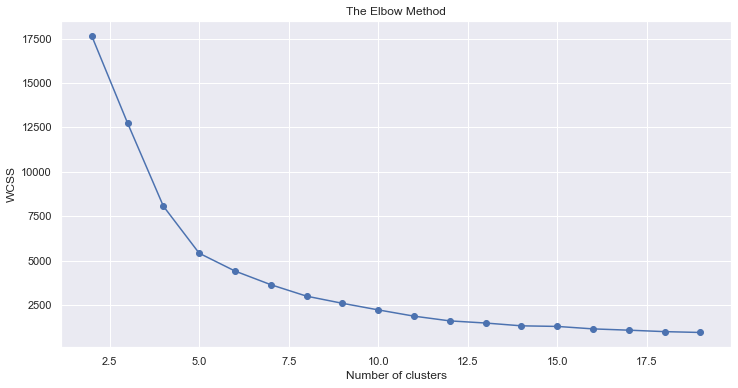

In [9]:
wcss = []
end_index =  20
for i in range(2, end_index):
    kmeans = KMeans(n_clusters = i, random_state = 10)
    kmeans.fit(pca_df.iloc[:,:-1])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(2, end_index), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

####  Using Silhouette analysis & Kmeans algorithm to find the ideal no. of clusters for the data

In [10]:
def get_best_num_of_clusters(data, start_index, end_index):

    print("\n-------------------- get_best_num_of_clusters --------------------\n")
    print(start_index,end_index)
    range_n_clusters = range(start_index,end_index)
    print(range_n_clusters)

    sil = []

    for num_of_clusters in range_n_clusters:

        clusterer = KMeans(n_clusters = num_of_clusters, random_state = 10)
        clusterer_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, clusterer_labels)
        if(silhouette_avg < 0.1):
            break
        sil.append(silhouette_avg)
        print("For n_clusters =", num_of_clusters, "The average silhouette_score :", silhouette_avg)

    ind = np.argmax(sil) + 2
    print("best_n_clusters: ", ind)   
    silhouette_max = np.amax(sil)

    return ind, silhouette_max

In [11]:
def cluster_faces_with_kmeans(pca_df_all_data, pca_df):
    
    best_n_clusters, silhouette_max = get_best_num_of_clusters(pca_df, 2, 30)
    clusterer = KMeans(n_clusters = best_n_clusters, random_state = 10)
    clusterer_labels = clusterer.fit_predict(pca_df)
    
    pca_df_all_data['cluster'] = clusterer_labels
    
    clustring_algorithms_results.append({"Name": "KMEANS", "silhouette_score": silhouette_max, "num_of_clusters": best_n_clusters})
    
    return pca_df_all_data, pca_df, silhouette_max
    

In [12]:
pca_df_all_data, pca_df, kmeans_sil_score = cluster_faces_with_kmeans(pca_df_all_data, pca_df)


-------------------- get_best_num_of_clusters --------------------

2 30
range(2, 30)
For n_clusters = 2 The average silhouette_score : 0.3223028792830674
For n_clusters = 3 The average silhouette_score : 0.3918840984147179
For n_clusters = 4 The average silhouette_score : 0.4989712613928893
For n_clusters = 5 The average silhouette_score : 0.5688438883271825
For n_clusters = 6 The average silhouette_score : 0.5469308538750911
For n_clusters = 7 The average silhouette_score : 0.5692125226472173
For n_clusters = 8 The average silhouette_score : 0.5462788000857761
For n_clusters = 9 The average silhouette_score : 0.5299158351939016
For n_clusters = 10 The average silhouette_score : 0.5434153292406267
For n_clusters = 11 The average silhouette_score : 0.5582339818637411
For n_clusters = 12 The average silhouette_score : 0.5764975365458453
For n_clusters = 13 The average silhouette_score : 0.5335035672772298
For n_clusters = 14 The average silhouette_score : 0.498136775839143
For n_cluste

In [13]:
pca_df_all_data.head()

,face_location,image_path,face_encodings,cluster
0,"[1222, 50, 1525, 432]",video.mp4,"[-1.1912599, -0.8228302, -0.40031707, -1.63635...",3
1,"[1249, 52, 1546, 434]",video.mp4,"[-1.2779435, -0.87038517, -0.37021828, -1.7669...",3
2,"[1250, 22, 1562, 430]",video.mp4,"[-1.0201672, -0.60240805, -0.6928619, -1.40743...",3
3,"[1299, 11, 1629, 441]",video.mp4,"[-1.1640614, -0.59016705, -0.5768476, -1.29468...",3
4,"[1324, 19, 1654, 440]",video.mp4,"[-0.95789826, -0.18442962, -0.9021818, -1.3385...",3


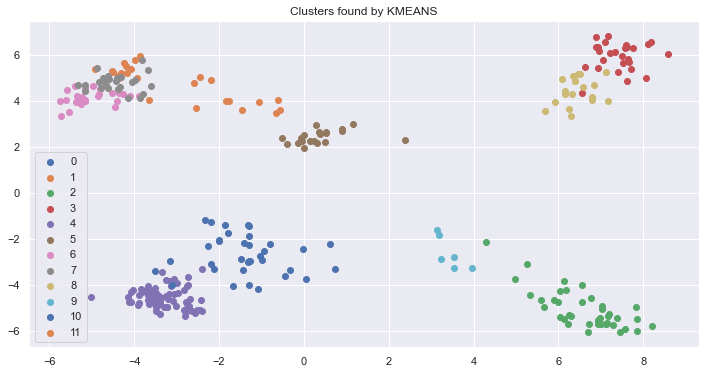

In [14]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "KMEANS")

### DBSCAN Algorithm

In order to understand how DBSCAN works, we have to define the following:

* **minPts**: minimun number of points (neighbors) that must exist within a circe of
  radius eps and center a specific point in order to classify it as core point.

* **eps**: defines the radius of neighborhood around a point x.

We classify all the points of a dataset as:

1. **core point**: if there are at least **MinPts** points within a circle of radius **eps**.
2. **border point**: if it contains at least 1 core point in its neighbor.
3. **noise point**: if it is neither a core point nor a border point.

##### DBSCAN Algorithm (simplified)
1. Scan the database.
2. Assign each point to one of the following categories: core point, border point or noise.
3. Reject all the noise points.
4. Connect all the core points within a distance ε and create a separate cluster.
5. Assign each border point to the cluster which is reachable from a core point.

#### Determine Optimal Epsilon And MinPts Values

**Approach #1 - Nearest Neighbors Approach - Using Euclidean distance method to find optimum epsilon distance(eps)**

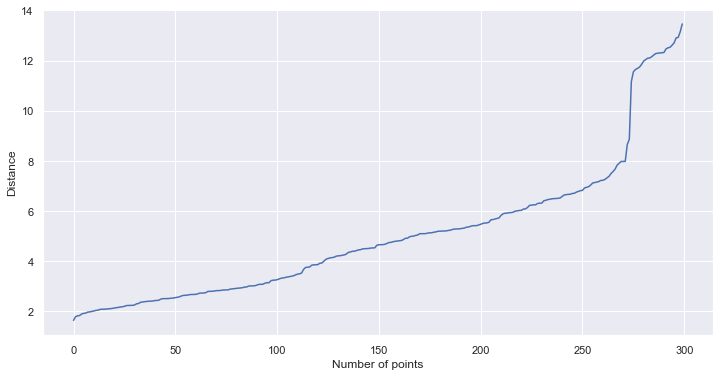

In [15]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=best_pca_dimensions * 2)
nbrs = neigh.fit(pca_df)
distances, indices = nbrs.kneighbors(pca_df)
distances = np.sort(distances[:,-1], axis = 0)
plt.figure(figsize=(12,6))
plt.plot(distances)
plt.xlabel('Number of points')
plt.ylabel('Distance')
plt.show()

**Approach #2 - Iteration Approach - Silhouette_score**

In [16]:
def plot_dbscan_parameters(all_dbscan_results_df):
    
    top = all_dbscan_results_df.nlargest(10, 'silhouette_score')
    
    fig, axs = plt.subplots(2, 2, figsize=(20,15))   
    
    x_data = ["({} , {})".format(eps,minPts) for eps,minPts in zip(top.minimum_points, top.epsilon_values)]
    axs[0,0].scatter(x_data, top.silhouette_score, color="#246EB9")
    axs[0,0].set_title("top 10 - (eps,minPts) vs silhouette_score")
    axs[0,0].set_ylim(0, 0.7)
    
    axs[0,1].bar(all_dbscan_results_df.minimum_points, all_dbscan_results_df.silhouette_score, color="#246EB9")
    axs[0,1].set_title("minimum_points vs silhouette_score")
    axs[0,1].set_ylim(0, 0.7)
    axs[0,1].set_xticks(np.arange(all_dbscan_results_df.minimum_points.min(), all_dbscan_results_df.minimum_points.max(), 1))
    
#     plt.xticks(np.arange(all_dbscan_results_df.minimum_points.min(), all_dbscan_results_df.minimum_points.max(), 1))
            
    axs[1,0].bar(all_dbscan_results_df.epsilon_values, all_dbscan_results_df.silhouette_score, color="#246EB9", width=0.3)
    axs[1,0].set_title("epsilon_values vs silhouette_score")
    axs[1,0].set_ylim(0, 0.7)
    axs[1,0].set_xticks(np.arange(all_dbscan_results_df.epsilon_values.min(), all_dbscan_results_df.epsilon_values.max(), 0.5))
    
      
    axs[1,1].bar(all_dbscan_results_df.no_of_clusters, all_dbscan_results_df.silhouette_score, color="#246EB9")
    axs[1,1].set_title("no_of_clusters vs silhouette_score")
    axs[1,1].set_ylim(0, 0.7)
    axs[1,1].set_xticks(np.arange(all_dbscan_results_df.no_of_clusters.min(), all_dbscan_results_df.no_of_clusters.max(), 1))

def get_optimal_parameters(data, eps_start_index, eps_end_index, eps_step, min_pts_start_index, min_pts_end_index):
      
    no_of_clusters = []
    sil_scores = []
    eps_values = []
    min_pts_values = []
    
    for eps in np.arange(eps_start_index,eps_end_index, eps_step):
        for min_pts in np.arange(min_pts_start_index, min_pts_end_index):
            
            labels, sil_score = start_dbscan(data,eps=eps, min_samples=min_pts)
                
            if sil_score is not None:
                eps_values.append(eps)
                min_pts_values.append(min_pts)
                no_of_clusters.append(len(np.unique(labels)))
                sil_scores.append(sil_score)
        
    all_dbscan_results = list(zip(no_of_clusters, sil_scores, eps_values, min_pts_values))
    all_dbscan_results_df = pd.DataFrame(all_dbscan_results, columns=['no_of_clusters', 'silhouette_score', 'epsilon_values', 'minimum_points'])
    
    plot_dbscan_parameters(all_dbscan_results_df)
    
    maxValueIndex = np.nanmax(all_dbscan_results_df.silhouette_score.astype("float").idxmax())
    
    best_parameters = all_dbscan_results_df.iloc[maxValueIndex]
    
    return best_parameters.epsilon_values, best_parameters.minimum_points

In [17]:
def start_dbscan(data, eps = 0.5, min_samples = 5):

    # print(eps, min_samples)

    # creating DBSCAN object for clustering the encodings with the metric "euclidean"
    dbscan_model = DBSCAN( eps = eps, min_samples = min_samples, n_jobs = 2, metric = "euclidean")

    # train the model
    dbscan_model.fit(data)

    labels = dbscan_model.labels_

    # determine the total number of unique faces found in the dataset
    # clt.labels_ contains the label ID for all faces in our dataset (i.e., which cluster each face belongs to).
    # To find the unique faces/unique label IDs, used NumPy’s unique function.
    # The result is a list of unique labelIDs
    label_ids = np.unique(dbscan_model.labels_)

    # we count the numUniqueFaces . There could potentially be a value of -1 in labelIDs — this value corresponds
    # to the “outlier” class where a 128-d embedding was too far away from any other clusters to be added to it.
    # “outliers” could either be worth examining or simply discarding based on the application of face clustering.
    num_unique_faces = len(np.where(label_ids > -1)[0])

    # print("[INFO] # unique faces: {}".format(num_unique_faces))

    n_noise_ = list(dbscan_model.labels_).count(-1)

    # print('Estimated number of noise points: %d' % n_noise_)

    if num_unique_faces > 1:
        sil_score = silhouette_score(data, labels)
        # print("Silhouette Coefficient: %0.3f" % sil_score)
        return labels, sil_score

    return labels , None

In [18]:
def cluster_faces_with_db_scan(pca_df_all_data, pca_df, best_pca_dimensions):
    
    eps_start_index = 1
    eps_end_index = 20
    eps_step = 0.5
    min_pts_start_index = 2
    min_pts_end_index = best_pca_dimensions * 2
    
    best_eps, best_min_samples = get_optimal_parameters(pca_df, eps_start_index, eps_end_index, eps_step, min_pts_start_index, min_pts_end_index)
    
    print("best_min_samples", best_min_samples, "best_eps", best_eps)
    
    # print("\n------------------------- start DBSCAN ------------------------------\n")

    labels, sil_score = start_dbscan(pca_df, eps = best_eps, min_samples = best_min_samples)
    pca_df_all_data['cluster'] = labels
    
    clustring_algorithms_results.append({"Name": "DBSCAN", "silhouette_score": sil_score, "num_of_clusters": len(np.unique(labels))})

    # print("\n------------------------- finish DBSCAN ------------------------------\n")

    return pca_df_all_data, pca_df,sil_score

best_min_samples 2.0 best_eps 6.0


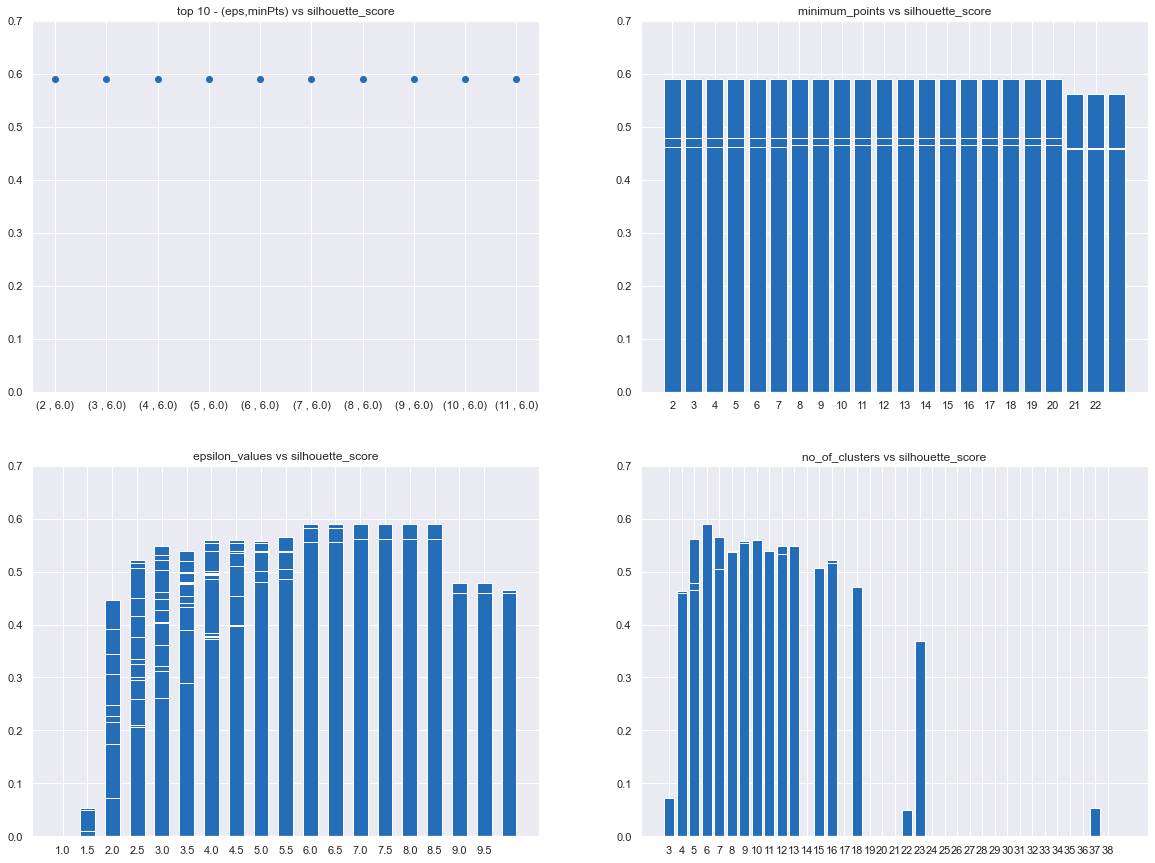

In [19]:
pca_df_all_data, pca_df, dbscan_sil_score = cluster_faces_with_db_scan(pca_df_all_data, pca_df, best_pca_dimensions)

In [20]:
pca_df_all_data

,face_location,image_path,face_encodings,cluster
0,"[1222, 50, 1525, 432]",video.mp4,"[-1.1912599, -0.8228302, -0.40031707, -1.63635...",0
1,"[1249, 52, 1546, 434]",video.mp4,"[-1.2779435, -0.87038517, -0.37021828, -1.7669...",0
2,"[1250, 22, 1562, 430]",video.mp4,"[-1.0201672, -0.60240805, -0.6928619, -1.40743...",0
3,"[1299, 11, 1629, 441]",video.mp4,"[-1.1640614, -0.59016705, -0.5768476, -1.29468...",0
4,"[1324, 19, 1654, 440]",video.mp4,"[-0.95789826, -0.18442962, -0.9021818, -1.3385...",0
...,...,...,...,...
295,"[1533, 452, 1830, 870]",video.mp4,"[-1.4184235, -0.6505166, -0.9390658, -0.624670...",0
296,"[737, 590, 985, 918]",video.mp4,"[-1.1496332, -0.26877365, -0.20659196, -0.3247...",5
297,"[1537, 469, 1833, 889]",video.mp4,"[-1.4349687, -0.41537136, -1.2884346, -0.72868...",0
298,"[779, 621, 1003, 923]",video.mp4,"[-1.1718473, -0.62041783, -0.26983872, -0.1617...",5


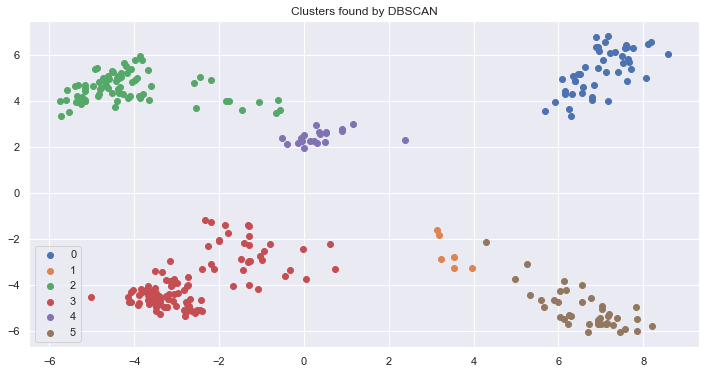

In [21]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "DBSCAN")

In [22]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453


### MeanShift clustering

In [23]:
from sklearn.cluster import estimate_bandwidth
def cluster_faces_with_meanshift(pca_df_all_data, pca_df):
    
    est_bandwidth = estimate_bandwidth(pca_df,quantile=.15,n_samples=10000)
    meanShift = MeanShift(bandwidth= est_bandwidth, bin_seeding=True)
    clusterer_labels = meanShift.fit_predict(pca_df)
    pca_df_all_data['cluster'] = clusterer_labels
    
    labels_unique=np.unique(clusterer_labels)
    n_clusters_=len(labels_unique)
    
    silh_score = 0
    
    if n_clusters_ > 1:
         silh_score = silhouette_score(pca_df, clusterer_labels)

    print("Number of estimated clusters : %d" % n_clusters_)
    
    clustring_algorithms_results.append({"Name": "MEANSHIFT", "silhouette_score": silh_score, "num_of_clusters": n_clusters_})
    
    return pca_df_all_data, pca_df, silh_score

In [24]:
pca_df_all_data, pca_df, meanshift_sil_score = cluster_faces_with_meanshift(pca_df_all_data, pca_df)

Number of estimated clusters : 6


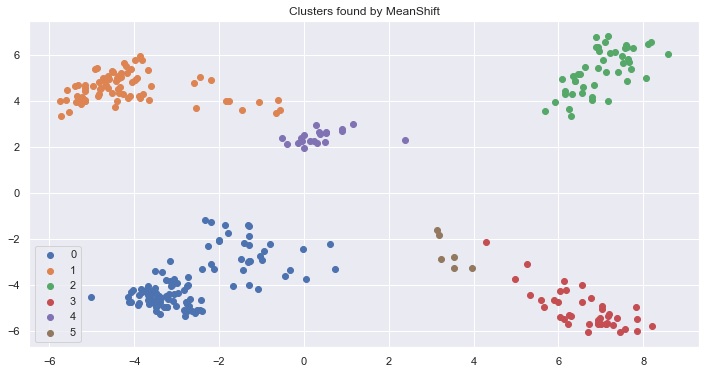

In [25]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "MeanShift")

In [26]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)
print("MEANSHIFT silhouette_score :", meanshift_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453
MEANSHIFT silhouette_score : 0.5893593940763328


### Hierarchical Clustering

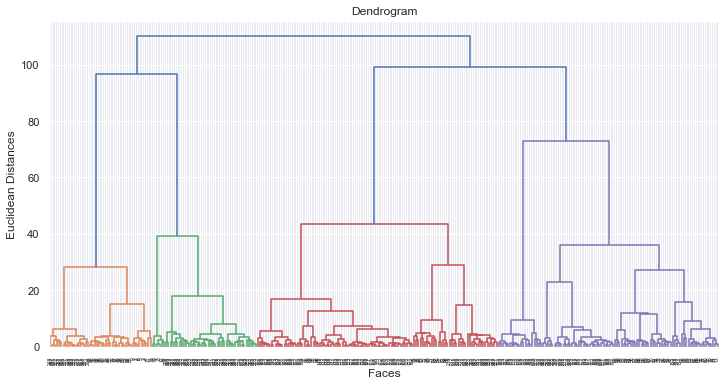

In [27]:
mergings = sch.linkage(pca_df, method = 'ward')
plt.figure(figsize=(12,6))
sch.dendrogram(mergings)
plt.title('Dendrogram')
plt.xlabel('Faces')
plt.ylabel('Euclidean Distances')
plt.show()

# By looking at this dendrogram, it can be seen that the optimal number of cluster is 5.
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
clusterer_labels = cluster.fit_predict(pca_df)
pca_df_all_data['cluster'] = clusterer_labels
hierarchical_sil_score = silhouette_score(pca_df, clusterer_labels, metric="euclidean")
clustring_algorithms_results.append({"Name": "HIERARCHICAL", "silhouette_score": hierarchical_sil_score, "num_of_clusters": 5})

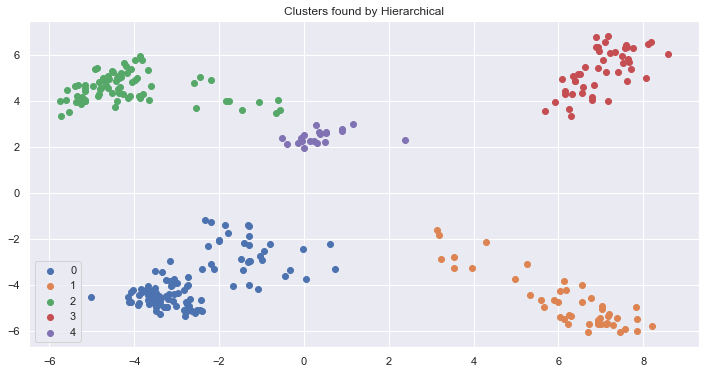

In [28]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "Hierarchical")

In [29]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)
print("MEANSHIFT silhouette_score :", meanshift_sil_score)
print("HIERARCHICAL silhouette_score :", hierarchical_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453
MEANSHIFT silhouette_score : 0.5893593940763328
HIERARCHICAL silhouette_score : 0.5688438883271825


### GMM Clustering

In [30]:
from sklearn.mixture import GaussianMixture

def get_best_k_paramerter(data, start_index, end_index):

    k_range = range(start_index, end_index) 

    pca_no_of_clusters = []
    pca_sil_score = []
    pca_k_values = []

    for k in k_range:
        
        # Apply your clustering algorithm of choice to the data
        clusterer = GaussianMixture(n_components=k, random_state=10)
        labels = clusterer.fit_predict(data)
        pca_k_values.append(k)
        pca_no_of_clusters.append(len(np.unique(labels)))
        pca_sil_score.append(silhouette_score(data,labels))

    pca_k_array = list(zip(pca_no_of_clusters, pca_sil_score, pca_k_values))
    pca_k_df = pd.DataFrame(pca_k_array, columns=['no_of_clusters', 'silhouette_score', 'k_values'])
    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=pca_k_df, x="k_values", y="silhouette_score")

    maxValueIndex = np.nanmax(pca_k_df.silhouette_score.idxmax())
    best_k = pca_k_df.iloc[maxValueIndex].k_values
    return int(best_k), pca_k_df.iloc[maxValueIndex].silhouette_score

def cluster_faces_with_GMM(pca_df_all_data, pca_df):
    
    k, silhouette_score_max = get_best_k_paramerter(pca_df, 2, best_pca_dimensions * 2)
    
    clusterer = GaussianMixture(n_components=k, random_state=10)
    clusterer_labels = clusterer.fit_predict(pca_df)
    
    pca_df_all_data['cluster'] = clusterer_labels
    
    print(silhouette_score_max, k)
    
    clustring_algorithms_results.append({"Name": "GMM", "silhouette_score": silhouette_score_max, "num_of_clusters": k})

    return pca_df_all_data, pca_df, silhouette_score_max

0.5688438883271825 5


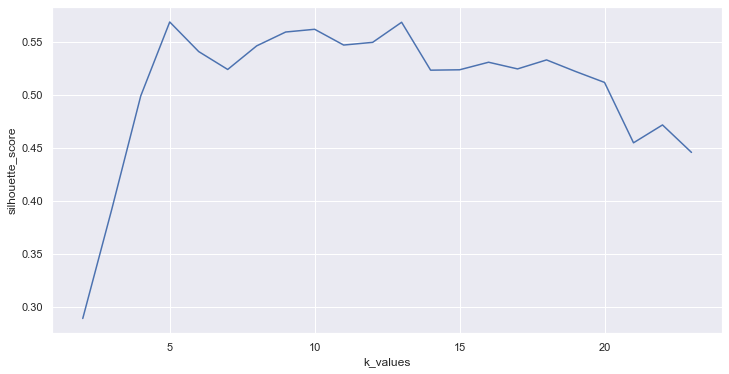

In [31]:
pca_df_all_data, pca_df, gmm_sil_score = cluster_faces_with_GMM(pca_df_all_data, pca_df)

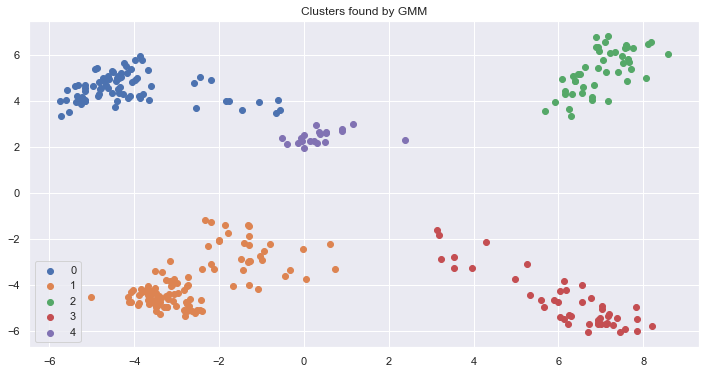

In [32]:
plot_clusters(pca_df, pca_df_all_data['cluster'], "GMM")

### Comparision of Results

In [33]:
print("DBSCAN silhouette_score :", dbscan_sil_score)
print("KMEANS silhouette_score :", kmeans_sil_score)
print("MEANSHIFT silhouette_score :", meanshift_sil_score)
print("HIERARCHICAL silhouette_score :", hierarchical_sil_score)
print("GMM silhouette_score :", gmm_sil_score)

DBSCAN silhouette_score : 0.5893593940763328
KMEANS silhouette_score : 0.5764975365458453
MEANSHIFT silhouette_score : 0.5893593940763328
HIERARCHICAL silhouette_score : 0.5688438883271825
GMM silhouette_score : 0.5688438883271825


In [34]:
clustring_algorithms_results = pd.DataFrame(clustring_algorithms_results)

In [35]:
clustring_algorithms_results

,Name,silhouette_score,num_of_clusters
0,KMEANS,0.576498,12
1,DBSCAN,0.589359,6
2,MEANSHIFT,0.589359,6
3,HIERARCHICAL,0.568844,5
4,GMM,0.568844,5


### Realtime Process

In [36]:
from tensorflow_object_detection import DetectorAPI

object_threshold = 0.98
odapi = DetectorAPI()
vs = cv2.VideoCapture("video.mp4")
rec = []

def draw_faces(image, face):
    (x, y, x1, y1) = [ v for v in face["face_location"]]
    cv2.rectangle(image, (x, y), (x1, y1), (255, 0, 0), 9)
        
def get_person_id(face_encodings, unknown_face_encoding):
    
    face_distances = []
    
    for face_encoding in face_encodings:
        face_distances.append(np.linalg.norm(face_encoding-unknown_face_encoding))
    
    best_match_index = np.argmin(face_distances)
    best_match = pca_df_all_data.iloc[best_match_index]
    
    return best_match

#Loop Video Stream   
while True:

    (grabbed, frame) = vs.read()

    if frame is None:
        break

    image = frame.copy()

    # Class 1 represents human
    persons = odapi.filter_detected_items(1, object_threshold, odapi, frame)
    
    # Visualization of the results of a detection.
    for person in persons:

        # Crop person from image
        y, x, y2, x2 = [ v for v in person["box"]]
        human = frame[y:y2, x:x2]

        # detect_faces
        faces = faceDetection.detect_faces(human, "video.mp4", 0.6)
        
        if(len(faces)==0):
            break
            
        face = faces[0]
        
        face_id = get_person_id(face_encodings, face["face_encoding"])
        
        human = cv2.resize(human, (300, 300))
        cv2.imshow('human',human)
        
        date = time.asctime(time.localtime(time.time()))
        rec.append({"time": date,"cluster":  face_id.cluster})
        
        print("start skeletons")
        
        skeletons, humans, scale_h = action_recognition.detect_skeletons(image)
        
        if(len(skeletons)==0):
            continue
            
        print("\ny", "x", "y2", "x2")
        print(y, x, y2, x2)
        
        image_w, image_h, _ = frame.shape
        
        for i, human in enumerate(humans):
        
            center = (int(human.body_parts[5].x * image_w + 0.5), int(human.body_parts[5].y * image_h + 0.5))
            
            allBodyPoints = None
            
            for i in 18:
                if(human.body_parts[i].x > 0 && human.body_parts[i].y > 0 ):
                    pointX = int(human.body_parts[i].x * image_w + 0.5)
                    pointY = int(human.body_parts[i].y * image_h + 0.5)
                    allBodyPoints.append((pointX, pointY))
            
            center = np.mean(data, axis=0)
            
            print(center)
            
            allBodyPoints = [ (human.body_parts[i].x, human.body_parts[i].y) for i in 18] 
            
            print(center)
            if(center[0] > x and center[0 < x2]):
                print("haliva")
                skeleton = skeletons[i]
                dict_id2skeleton = action_recognition.people_track(skeletons)
                dict_id2label = action_recognition.recognize_action(dict_id2skeleton)
            print("---------------------label---------------", dict_id2label)
        

    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break


cv2.destroyAllWindows()

In [37]:
rec = pd.DataFrame(rec)
rec

NameError: name 'rec' is not defined

### Spark Clustering - KMEANS

In [42]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans as SparkKmeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark import SparkConf

spark = SparkSession.builder.appName("cruise1").getOrCreate()
feat_cols = [str(i) for i in range(0, best_pca_dimensions)]

sparkDf = spark.createDataFrame(pca_df)

vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol="features")
cluster_final_data = vec_assembler.transform(sparkDf)

In [43]:
evaluator = ClusteringEvaluator()

sil = []

for k in range(2,20):
    kmeans = SparkKmeans(featuresCol = 'features', k=k, seed=10)
    model_k = kmeans.fit(cluster_final_data)
    predictions = model_k.transform(cluster_final_data)
    silhouette = evaluator.evaluate(predictions)
    sil.append(silhouette)
    print("with K={}".format(k))
    print("with silhouette={}".format(silhouette))

ind = np.argmax(sil) + 2
print("best_n_clusters: ", ind)   
silhouette_max = np.amax(sil)
print("best_silhouette={}".format(silhouette_max))

with K=2
with silhouette=0.3307020842686031
with K=3
with silhouette=0.48501920437754015
with K=4
with silhouette=0.5066164150968113
with K=5
with silhouette=0.6882482688052228
with K=6
with silhouette=0.7858728170391831
with K=7
with silhouette=0.7590125293888434
with K=8
with silhouette=0.7154629770060749
with K=9
with silhouette=0.7011274204499452
with K=10
with silhouette=0.7169544803330058
with K=11
with silhouette=0.7415970202076416
with K=12
with silhouette=0.7144538698641792
with K=13
with silhouette=0.6495615366310327
with K=14
with silhouette=0.6960816191774026
with K=15
with silhouette=0.7220179513352218
with K=16
with silhouette=0.7017481148103735
with K=17
with silhouette=0.678787758005798
with K=18
with silhouette=0.615411822181274
with K=19
with silhouette=0.6187120557339646
best_n_clusters:  6
best_silhouette=0.7858728170391831


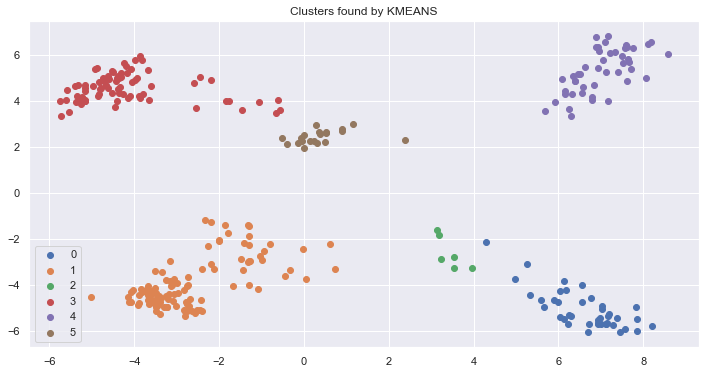

In [44]:
kmeans = SparkKmeans(featuresCol = 'features', k=ind)
model_k = kmeans.fit(cluster_final_data)
predictions  = model_k.transform(cluster_final_data).select('prediction').collect()
labels = [p.prediction for p in predictions ]
plot_clusters(pca_df, labels, "KMEANS")

### Spark Clustering - GMM

with K=2
with silhouette=0.10146679472655819
with K=3
with silhouette=0.32145017272458604
with K=4
with silhouette=0.3156090227724592
with K=5
with silhouette=0.16309178874030228
with K=6
with silhouette=0.1503173180232295
with K=7
with silhouette=0.1271714639292572
with K=8
with silhouette=0.03814626370021831
with K=9
with silhouette=0.04579192758411788
with K=10
with silhouette=0.08576274944169845
with K=11
with silhouette=0.13630480046574744
with K=12
with silhouette=0.09873276670532964
with K=13
with silhouette=0.09178373908100573
with K=14
with silhouette=0.04393624655579751
with K=15
with silhouette=-0.032087836665338564
with K=16
with silhouette=-0.02481975227047865
with K=17
with silhouette=-0.06011474400772499
with K=18
with silhouette=0.1258844787589919
with K=19
with silhouette=0.03941956155140316
best_n_clusters:  3
best_silhouette=0.32145017272458604


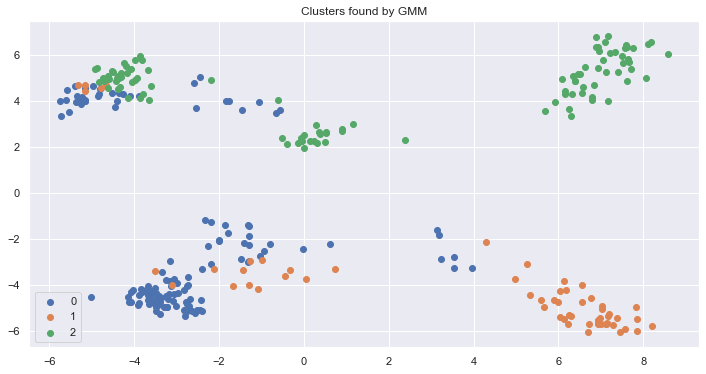

In [45]:
from pyspark.ml.clustering import GaussianMixture as GMM

sil = []

for k in range(2,20):
    gmm = GMM(seed=10).setK(k)
    model_k = gmm.fit(cluster_final_data)
    predictions = model_k.transform(cluster_final_data)
    silhouette = evaluator.evaluate(predictions)
    sil.append(silhouette)
    print("with K={}".format(k))
    print("with silhouette={}".format(silhouette))

ind = np.argmax(sil) + 2
print("best_n_clusters: ", ind)   
silhouette_max = np.amax(sil)
print("best_silhouette={}".format(silhouette_max))

# Trains Gaussian Mixture Model
gmm = GMM(seed=10).setK(ind)
model_k = gmm.fit(cluster_final_data)
predictions = model_k.transform(cluster_final_data).select('prediction').collect()
labels = [p.prediction for p in predictions ]
plot_clusters(pca_df, labels, "GMM")